# Riemannian Brownian Mixture Model

In [1]:
#Modules

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.statistics.score_matching import BrownianMixture
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-04-30 00:07:48.535325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
t0 = 0.01
score_path = "scores"
s2_approx = 0
s1loss_type = "dsmvr"
s2loss_type = "dsmvr"
s2_type = "s1s2"
seed = 2712
K = 4

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers = get_generator_dim(generator_dim)

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers), 
                    models.MLP_s2(layers_alpha=layers, 
                                  layers_beta=layers,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Testing with $\mathbb{R}^{2}$

In [4]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)

using M.Exp for Logarithm


### Generate Test Data

In [5]:
eps = 0.1*np.random.normal(size=(100,2))
x = []
centers = [jnp.array([-1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([1.0,0.0]), jnp.array([0.0,-1.0])]
for i in range(K):
    eps = 0.1*np.random.normal(size=(100,2))
    x.append(eps+centers[i])
x = jnp.vstack(x)

X_obs = (x, jnp.zeros(len(x)).reshape(-1))

### Testing with True Gradient

In [6]:
RBMM = BrownianMixture(M=M,
                       grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                       gradt_log=lambda x,y,t: M.gradt_log_hk(x,y,t),
                       n_clusters=K,
                       eps=0.1,
                       method='Local',
                       update_method="Gradient",
                       max_iter=1000,
                       lr=0.01,
                       dt_steps=100,
                       min_t=1e-3,
                       max_t=1.0,
                       seed=2712,
                      )

In [7]:
mu_init = (jnp.stack((X_obs[0][0], X_obs[0][1], X_obs[0][2], X_obs[0][3])),
          jnp.stack((X_obs[1][0], X_obs[1][1], X_obs[1][2], X_obs[1][3])))
mu_init = (jnp.stack((jnp.array([1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([-1.0,0.0]), jnp.array([0.0,-1.0]))),
          jnp.zeros(4).reshape(4,-1))
T = 0.5

In [8]:
RBMM.density((X_obs[0][200], X_obs[1][200].reshape(1)),
            (mu_init[0][0], mu_init[1][0].reshape(1)),
            jnp.array([0.5]))

Array(175.43638657, dtype=float64)

In [9]:
mu_init[0][0]

Array([1., 0.], dtype=float64)

In [10]:
mu_init[0]

Array([[ 1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.]], dtype=float64)

In [11]:
X_obs[0][0]

Array([-0.93989382, -0.06166994], dtype=float64)

In [12]:
s1_model = lambda x,y,t: M.grady_log_hk(x,y,t)[0]
t = 0.1
T = 0.5
s1_model((mu_init[0][0], mu_init[1][0]), (mu_init[0][0], mu_init[1][0]), T-t)

Array([0., 0.], dtype=float64)

In [13]:
s1_model((mu_init[0][0], mu_init[1][0]), (X_obs[0][0], X_obs[1][0]), T-t)

Array([4.84973454, 0.15417485], dtype=float64)

In [14]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)), mu_init=mu_init)

In [15]:
RBMM.mu

(Array([[-0.00084526, -0.01386551],
        [-0.00108596, -0.01362481],
        [-0.00132666, -0.01386551],
        [-0.00108596, -0.01410621]], dtype=float64),
 Array([[0.],
        [0.],
        [0.],
        [0.]], dtype=float64))

In [16]:
RBMM.T

Array([0.45, 0.45, 0.45, 0.45], dtype=float64)

In [17]:
RBMM.pi

Array([0.25, 0.25, 0.25], dtype=float64)

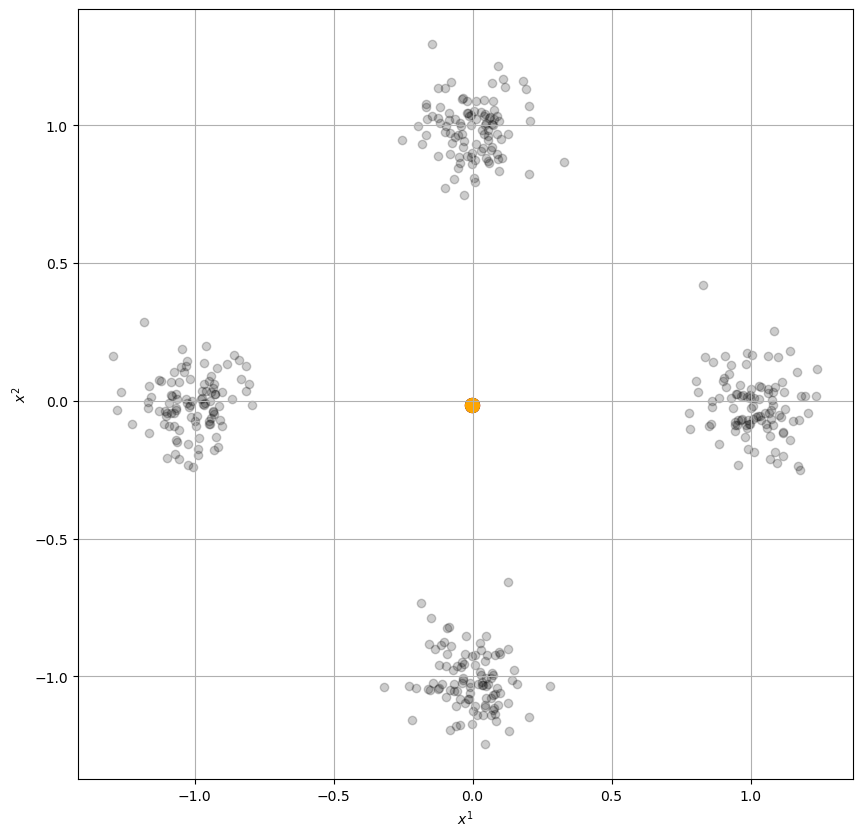

In [18]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
ax.scatter(X_obs[0][:,0], 
           X_obs[0][:,1], alpha=0.2, color="black", label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

In [19]:
pt = vmap(lambda x,c: vmap(lambda mu_x,mu_c,t: RBMM.test((x,c),(mu_x,mu_c), t))(RBMM.mu[0],
                                                                                    RBMM.mu[1],
                                                                                    RBMM.T))(X_obs[0],
                                                                                                        X_obs[1])

In [20]:
jnp.log(pt[0])

Array([[5.61383158, 5.61384096, 5.6138479 , 5.61383852],
       [5.61718097, 5.61718788, 5.61719584, 5.61718893],
       [5.61213282, 5.61214179, 5.61215007, 5.61214109],
       ...,
       [5.61123606, 5.6112269 , 5.61123537, 5.61124453],
       [5.60780442, 5.60779408, 5.60780272, 5.60781306],
       [5.61074516, 5.61073672, 5.61074612, 5.61075456]], dtype=float64)

In [21]:
pt

(Array([[274.19281872, 274.19539116, 274.19729505, 274.19472258],
        [275.11273803, 275.11463885, 275.11682861, 275.11492778],
        [273.7274267 , 273.72988343, 273.73214781, 273.72969105],
        ...,
        [273.48206916, 273.47956336, 273.48188117, 273.48438698],
        [272.54518586, 272.54236822, 272.54472333, 272.54754099],
        [273.3478502 , 273.34554379, 273.34811192, 273.35041834]],      dtype=float64),
 (Array([[[-0.05952225,  0.00349107],
          [-0.05974925,  0.00371806],
          [-0.05997625,  0.00349107],
          [-0.05974925,  0.00326407]],
  
         [[-0.05420588, -0.0092405 ],
          [-0.05443288, -0.0090135 ],
          [-0.05465988, -0.0092405 ],
          [-0.05443288, -0.0094675 ]],
  
         [[-0.06288704, -0.00284277],
          [-0.06311403, -0.00261577],
          [-0.06334103, -0.00284277],
          [-0.06311403, -0.00306977]],
  
         ...,
  
         [[ 0.00256637, -0.06977751],
          [ 0.00233937, -0.06955051],
        

In [22]:
pt[0]

Array([[274.64731461, 274.6495431 , 274.65163409, 274.64940559],
       [274.52021488, 274.52260691, 274.52457411, 274.52218206],
       [275.24044699, 275.24239963, 275.24448272, 275.24253007],
       ...,
       [273.94650086, 273.94428462, 273.94669765, 273.94891391],
       [275.30569696, 275.30379247, 275.30588955, 275.30779405],
       [275.56909392, 275.56720615, 275.56918892, 275.57107671]],      dtype=float64)

In [23]:
RBMM.mu[0]

Array([[0.00211051, 0.00108808],
       [0.00186981, 0.00132878],
       [0.00162911, 0.00108808],
       [0.00186981, 0.00084738]], dtype=float64)

In [24]:
pt[1][0][:,0]

Array([[-5.53003872e-02,  2.91539174e-03],
       [-5.58552181e-02,  6.73616407e-03],
       [-5.14142663e-02, -6.41451233e-04],
       [-4.79065119e-02,  1.12660195e-03],
       [-4.75185268e-02,  1.03923983e-02],
       [-5.40191300e-02,  3.69438893e-03],
       [-5.67812650e-02,  6.80905679e-03],
       [-4.76771786e-02,  9.03785952e-03],
       [-5.67528129e-02,  5.29498203e-04],
       [-6.46041825e-02,  1.00099365e-02],
       [-5.40117130e-02,  9.69669145e-03],
       [-5.01399978e-02, -9.16034059e-04],
       [-4.09660345e-02,  5.52077386e-04],
       [-5.85729700e-02, -2.26191150e-03],
       [-4.53582968e-02, -1.86042304e-03],
       [-4.53431636e-02,  8.40342374e-03],
       [-6.04026336e-02, -4.96848213e-03],
       [-6.55865993e-02, -5.09666186e-03],
       [-6.27014061e-02,  1.07538034e-04],
       [-4.92408965e-02,  2.65325631e-03],
       [-5.79596011e-02,  2.72825005e-03],
       [-5.83221397e-02,  9.85581276e-03],
       [-5.68567490e-02, -2.36653200e-03],
       [-5.

In [25]:
RBMM.p0((X_obs[0][10], X_obs[1][10]), (RBMM.mu[0][0], RBMM.mu[1][0]), 0.5)

Array(0.01099141, dtype=float64)